In [67]:
import torch

from model.GCN_classifier import TimeDiffClassifier
from model.GCN_classifier import TimeDiffClassifier_sagpooling

import pytorch_lightning as pl

import os.path as osp
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hparams = {}
hparams['batch_size'] = 32
hparams['num_classes'] = 2
hparams['hidden_channels'] = 64
#hparams['num_node_features'] = 149
hparams['batch_size'] = 32
hparams['lr'] = 1.0e-03
hparams['weight_decay'] = 5.0e-06

s='./data_diff'
hparams['s_data'] = osp.join(*(s.split('/')))
s='./data/DT_File_MAP.xlsx'
hparams['s_node'] = osp.join(*(s.split('/')))
s='./data/[UNC]ADNI-network/dataTS.csv'
hparams['s_date'] = osp.join(*(s.split('/')))
s = './sparsification/data'
hparams['s_sparsified'] = osp.join(*(s.split('/'))) + osp.sep


#model.prepare_data()





cpu


In [4]:
model = TimeDiffClassifier(hparams)
model = model.to(device)

trainer = None

epochs = 300

logdir = './lightning_logs'
network_logger = pl.loggers.TensorBoardLogger(
    save_dir=logdir,
    name='TimeDiffClassify_logs'
)
logger = network_logger

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
)

In [5]:
trainer = pl.Trainer(max_epochs=epochs, early_stop_callback=early_stopping)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
C:\Users\rlckd\Anaconda3\envs\graph_matching\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name              | Type           | Params
-------------------------------------------------
0 | model             | GCN            | 22 K  
1 | model.conv1       | GCNConv        | 9 K   
2 | model.conv2       | GCNConv        | 4 K   
3 | model.conv3       | GCNConv        | 4 K   
4 | model.att         | GlobalAtt_gate | 65    
5 | model.att.gate_nn | Linear         | 65    
6 | model.lin1        | Linear         | 4 K   
7 | model.lin2        | Linear         | 130   


Number of training graphs: 103
Number of validation graphs: 12
Number of test graphs: 14


1

In [65]:
model.eval()
_, acc =  model.getTestAcc()
acc

0.7142857142857143

In [6]:
trainer.test(model)

Number of training graphs: 103
Number of validation graphs: 12
Number of test graphs: 14


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.7142857142857143, 'test_loss': tensor(0.3407)}
--------------------------------------------------------------------------------



<BarContainer object of 148 artists>

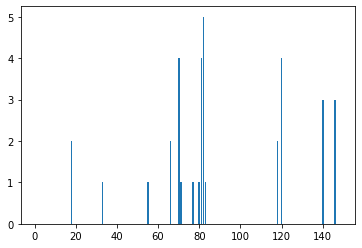

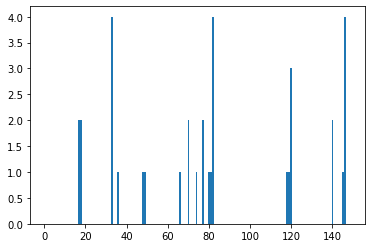

In [58]:
topk = 5
model.model.eval()
cnt_dict = []
cnt_dict.append({i+1:0 for i in range(148)})
cnt_dict.append({i+1:0 for i in range(148)})
for d  in model.dataset['test']:
    #print(d.y)
    att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
    #att.shape
    att_values = {}
    att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
    
    #att_values
    l = list({k: v for k, v in sorted(att_values.items(), key=lambda item: item[1], reverse = True)}.keys())
    for tk in l[:topk]:
        cnt_dict[d.y][tk] = cnt_dict[d.y][tk]+1
plt.figure(0)
plt.bar(cnt_dict[0].keys(),cnt_dict[0].values())
plt.figure(1)
plt.bar(cnt_dict[1].keys(),cnt_dict[1].values())

<BarContainer object of 148 artists>

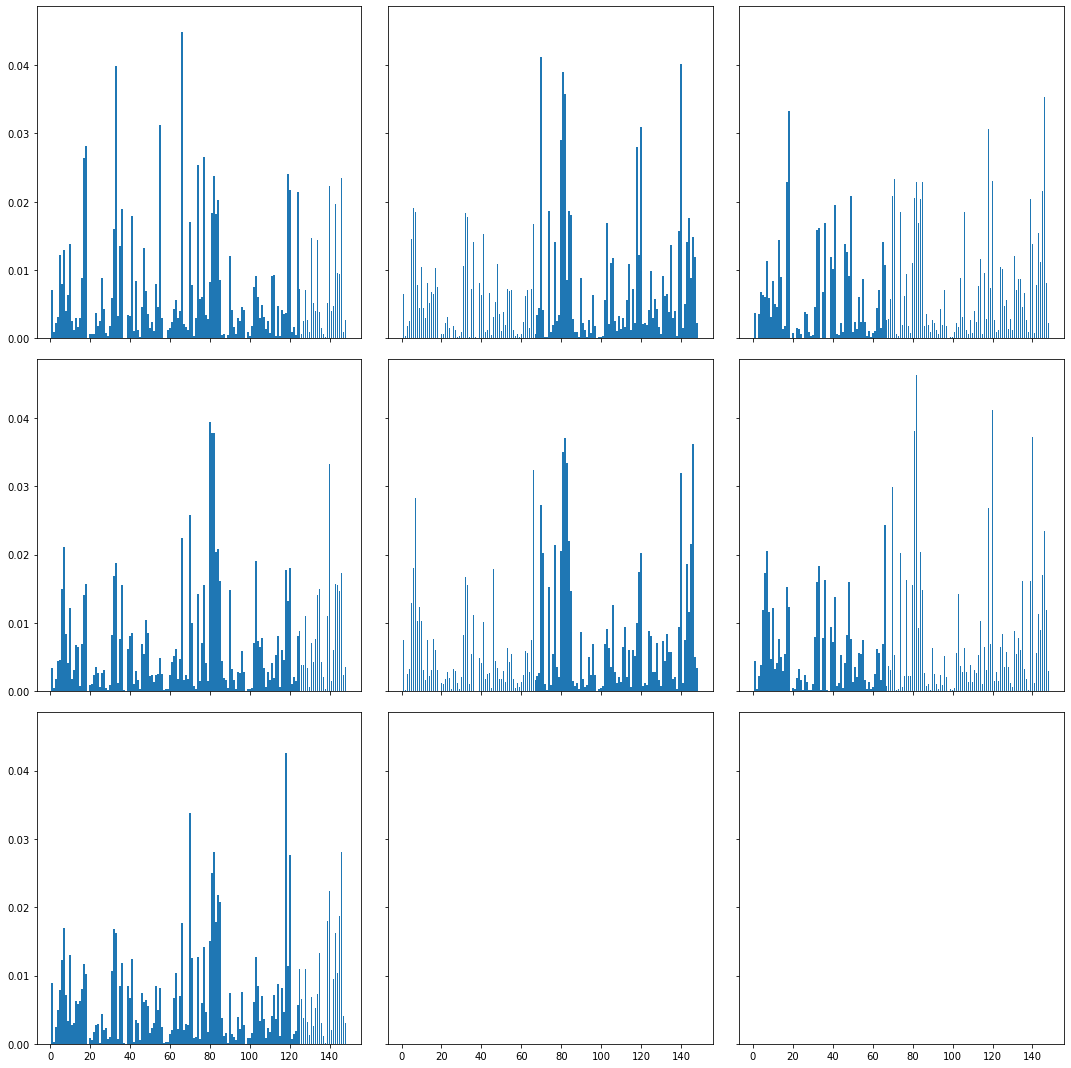

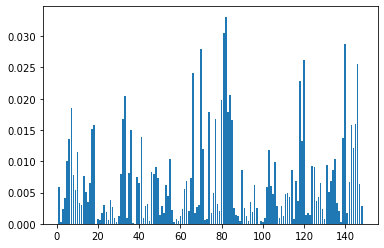

In [87]:
model.model.eval()
nrows = 3
ncols = 3
fig, axes = plt.subplots(figsize=(15, 15) , nrows = nrows, ncols = ncols, sharex='all', sharey='all')
fig.tight_layout()

cnt = 0
avg_dict0 = {i+1:0 for i in range(148)}
for tc,d  in enumerate(model.dataset['test']):
    #print(d.y)
    if(d.y == 0) :
        ax = axes[cnt//ncols][cnt%ncols]
        cnt = cnt+1
        att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
        #att.shape
        att_values = {}
        att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
        for j in range(148):
            i=j+1
            avg_dict0[i] = avg_dict0[i] + att_values[i]
        ax.bar(att_values.keys(),att_values.values())

avg_dict0 = {i+1:(avg_dict0[i+1]/cnt) for i in range(148)}
plt.figure(0)
plt.bar(avg_dict0.keys(),avg_dict0.values())

<BarContainer object of 148 artists>

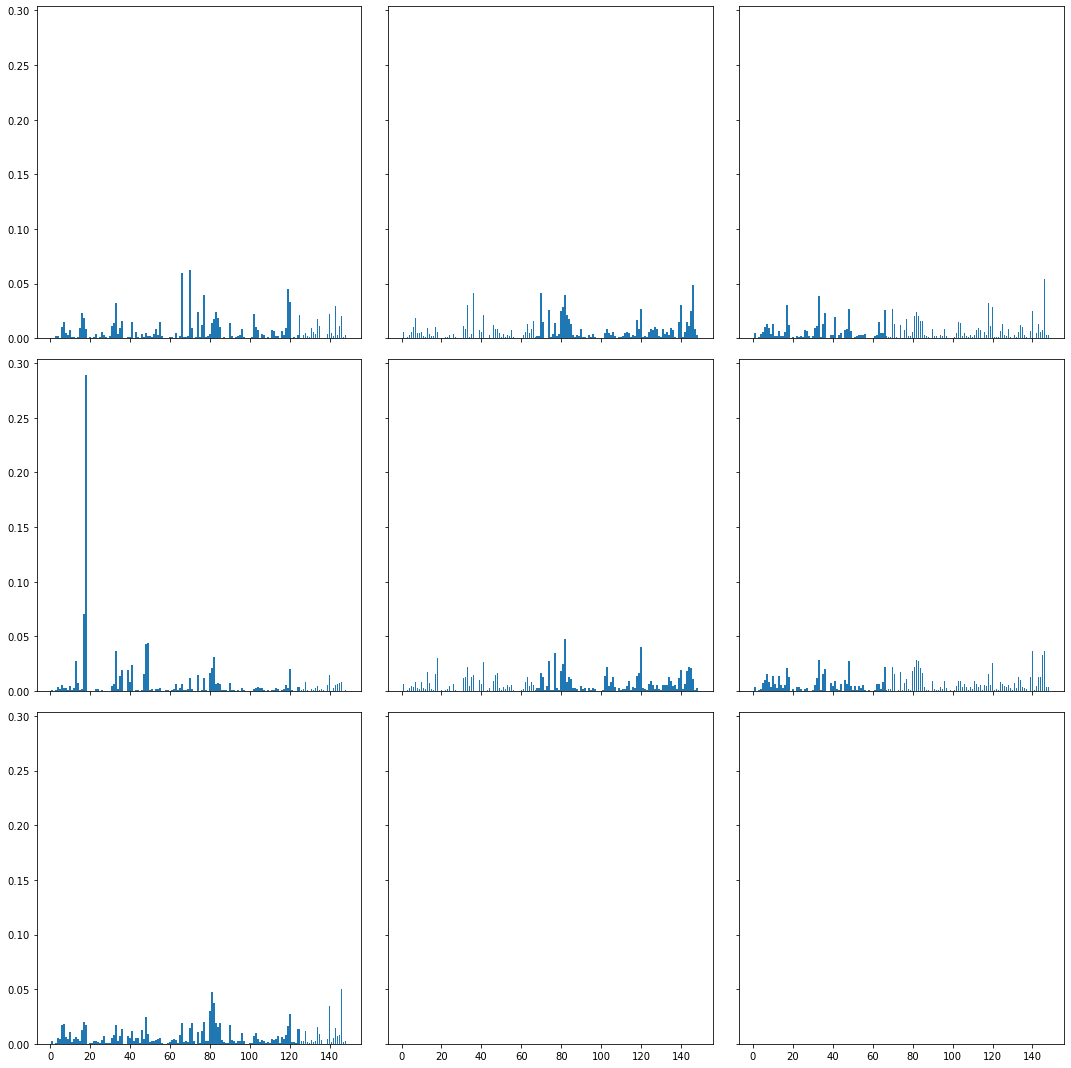

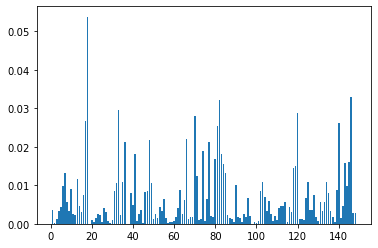

In [93]:
model.model.eval()
nrows = 3
ncols = 3
fig, axes = plt.subplots(figsize=(15, 15) , nrows = nrows, ncols = ncols, sharex='all', sharey='all')
fig.tight_layout()

cnt = 0
avg_dict1 = {i+1:0 for i in range(148)}
for tc,d  in enumerate(model.dataset['test']):
    #print(d.y)
    if(d.y == 1) :
        ax = axes[cnt//ncols][cnt%ncols]
        cnt = cnt+1
        att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
        #att.shape
        att_values = {}
        att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
        for j in range(148):
            i=j+1
            avg_dict1[i] = avg_dict1[i] + att_values[i]
        ax.bar(att_values.keys(),att_values.values())

avg_dict1 = {i+1:(avg_dict1[i+1]/cnt) for i in range(148)}
plt.figure(0)
plt.bar(avg_dict1.keys(),avg_dict1.values())

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hparams = {}
hparams['split_train'] = 0.7
hparams['split_val'] = 0.2


hparams['batch_size'] = 32
hparams['num_classes'] = 2
#hparams['num_classes'] = 3

hparams['hidden_channels'] = 64
hparams['num_node_features'] = 149
hparams['num_layers'] = 3
## 6 --> 2
## 8 --> 3개가 쓰인다.
hparams['ratio'] = 0.8

hparams['batch_size'] = 32
hparams['lr'] = 3.0e-04
#hparams['lr'] = 5.0e-05

hparams['weight_decay'] = 1.0e-6
#hparams['weight_decay'] = 1.0e-4

#hparams['use_base_edge'] = True
hparams['use_base_edge'] = False


s='./data_diff'
#s='./data_diff_base'
hparams['s_data'] = osp.join(*(s.split('/')))
s='./data/DT_File_MAP.xlsx'
hparams['s_node'] = osp.join(*(s.split('/')))
s='./data/[UNC]ADNI-network/dataTS.csv'
hparams['s_date'] = osp.join(*(s.split('/')))
s = './sparsification/data'
hparams['s_sparsified'] = osp.join(*(s.split('/'))) + osp.sep


#model.prepare_data()



cpu


In [104]:
model = TimeDiffClassifier_sagpooling(hparams)
model = model.to(device)

trainer = None

epochs = 300
min_epochs = 100

logdir = './lightning_logs'
network_logger = pl.loggers.TensorBoardLogger(
    save_dir=logdir,
    name='TimeDiffClassify_logs'
)
logger = network_logger

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
)
model.model

SAGPool(
  (conv1): GraphConv(149, 64)
  (convs): ModuleList(
    (0): GraphConv(64, 64)
    (1): GraphConv(64, 64)
  )
  (pools): ModuleList(
    (0): SAGPooling(GraphConv, 64, ratio=0.8, multiplier=1)
  )
  (jump): JumpingKnowledge(cat)
  (lin1): Linear(in_features=192, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [105]:
trainer = pl.Trainer(max_epochs=epochs, early_stop_callback=early_stopping, min_epochs = min_epochs)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

   | Name                    | Type             | Params
---------------------------------------------------------
0  | model                   | SAGPool          | 48 K  
1  | model.conv1             | GraphConv        | 19 K  
2  | model.conv1.lin_l       | Linear           | 9 K   
3  | model.conv1.lin_r       | Linear           | 9 K   
4  | model.convs             | ModuleList       | 16 K  
5  | model.convs.0           | GraphConv        | 8 K   
6  | model.convs.0.lin_l     | Linear           | 4 K   
7  | model.convs.0.lin_r     | Linear           | 4 K   
8  | model.convs.1           | GraphConv        | 8 K   
9  | model.convs.1.lin_l     | Linear           | 4 K   
10 | model.convs.1.lin_r     | Linear           | 4 K   
11 | model.pools             | ModuleList       | 129   
12 | model.pools.0           | SAGPooling       | 129   
13 | model.pools.0.gnn       | GraphConv        | 12

Number of training graphs: 90
Number of validation graphs: 25
Number of test graphs: 14


torch.Size([25, 2])


torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([26, 2])


torch.Size([25, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([26, 2])


torch.Size([25, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([26, 2])


torch.Size([25, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([26, 2])


torch.Size([25, 2])
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([26, 2])


Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [16]:

trainer.test(model)

Number of training graphs: 103
Number of validation graphs: 12
Number of test graphs: 14


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.8571428571428571, 'test_loss': tensor(1.0532)}
--------------------------------------------------------------------------------



In [33]:
hparams['ratio']**((hparams['num_layers']-1)/2)

0.457946721791957

In [34]:
0.8**3*148

75.77600000000002

In [35]:
148*0.8

118.4

In [77]:
model.dataset['test']

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tensor([2])
-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([ 89,  88, 103, 102,  98, 107,  23,   0,  97, 116,  90,  85, 145, 146,
          5, 110,  92,  99, 108, 111,  91,  31, 120,  65,  30, 114,  77,  69,
        127, 122,  22, 101,  76,  42,  96, 140,  62,  49,  87,   4,  17,  15,
        106,  74, 118,  37,  79,  78, 100,  18,  59,  75, 112, 133, 123, 142,
          1,  20, 132,  47,  33,  36,  71,  29, 125, 126,  14,  13,  21, 139,
         72,  63,  48, 113,  60, 135,  16, 104,  32,  19, 141, 115,  12,  58,
        136,  40,  51,  73,  80,  34, 143,  46,  38, 105,  57,  35,  52,  25,
          3,  50, 137,  86,  61, 134,   2, 124,  11, 129, 121, 128,  81,  82,
          7,   6,  39,  93, 119, 117, 138])
tensor([ 0.9984,  0.9960,  0.9797,  0.9755,  0.9728,  0.9600,  0.9398,  0.9227,
         0.8986,  0.8893,  0.8882,  0.8828,  0.8572,  0.8534,  0.8488,  0.8362,
         0.8246,  0.7714,  0.7616,  0.7601,  0.7549,  0.7510,  0.7387,  0.7376,
       

-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([ 89,  88, 122, 102, 118, 141,  76,  77, 127,  98, 100, 125, 139, 142,
        110,   0,  23, 120,  15,  79, 103,  30,   5,  99, 129,  69, 101, 140,
         31,  85,  17,  92,  16, 107,  62,  22, 146,  63,  48,  97, 112, 114,
        132,  34, 135, 111,  91,  65,  90,   4,  75, 128,  72,  93, 115,  33,
         29,  87, 109,  40, 119, 138,   6,  12,  46, 123,  73,  43, 144,  25,
          8, 108,  84,  21,  86,  60, 113,  74, 117,  59, 136,  61,  47, 145,
         49, 104,  36,  20,  83,  13,  10,  95,  19,  32,  42,  58,   1,  35,
        124,  50,  82,  51,  96, 106,  38,  41,  39, 126, 131, 134, 121, 105,
         71,  44,  14,  52,   3,   9,  28])
tensor([ 0.9290,  0.9139,  0.9094,  0.8761,  0.8059,  0.7667,  0.6848,  0.6643,
         0.6592,  0.6071,  0.6047,  0.6034,  0.5959,  0.5943,  0.5660,  0.5603,
         0.5498,  0.5478,  0.5433,  0.5395,  0.5293,  0.5179,  0.5047,  0.4921,
         0.4692,  0.4517,  0.4314,  0.4236,  0.4

       grad_fn=<IndexBackward>)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([  1,   0,   2,   8,   3,   6,  18,  29,  21,  13,  64,  31,  43,  19,
          7,   4,  14,  66,  24,  12,  91,  48,  42,  44,  22,  72,  49,   5,
         41,  88,  79,  55, 109,  50,  15,  70, 110,  54,  97,  34,  38,  11,
         61, 117, 102,  23,  26,  17,  10,  25,  45,  16,   9,  92,  30,  27,
        113,  90,  59,  84,  35,  67,  93,  39,  47,  28,  20,  56,  51,  62,
         63,  73,  96,  69,  60, 115,  71,  32,  53,  87,  80,  75,  82,  83,
         78,  81,  58, 104,  46,  85,  94, 100,  52,  65,  95,  98])
tensor([ 0.9662,  0.9647,  0.9116,  0.9078,  0.8953,  0.8899,  0.8865,  0.8268,
         0.7811,  0.7765,  0.7395,  0.6637,  0.6460,  0.6431,  0.6301,  0.5547,
         0.4611,  0.4306,  0.4174,  0.4079,  0.3889,  0.3835,  0.3806,  0.3751,
         0.3658,  0.3656,  0.3298,  0.2418,  0.2040,  0.2030,  0.1913,  0.1885,
         0.1581,  0.1522,  0.1475,  0.1467,  0.1319,  0.1310,  0.1123,  0.0896,
  

-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([103, 129,  89, 100, 121,  93, 102, 138,  92,  97, 146,  33,  76, 107,
         29,  59, 108,   1,  18,  90,  88, 122,  98, 120,  22,  36,  85, 140,
         84,  20,  23,  17, 118,  99,  77,  15, 144,  49,  60,   0,  58,  82,
        141, 110,  91,  72, 119,  62,  94,  56, 139,  79,  21, 117, 114,  69,
         13,  86,  12,  71,  41,  81,  63, 135,  30,  31,  50, 145, 116,  26,
        111, 115,   4,  96, 106,  34,  61, 132,  74,  42,  83,  37,  48, 125,
         46,  40,   3,   5, 101, 112, 127,  47,  87, 142, 131,  25,  14, 137,
         73,  75, 143,   9,  38,  19,   2,  68,  80, 123, 130, 126,  43,  32,
         78,  51, 128, 109,  10, 133,  35])
tensor([ 0.9561,  0.9527,  0.9219,  0.9105,  0.8889,  0.8542,  0.8497,  0.8445,
         0.8306,  0.8009,  0.7977,  0.7878,  0.7759,  0.7508,  0.7399,  0.7335,
         0.7115,  0.7082,  0.6867,  0.6783,  0.6573,  0.6412,  0.6384,  0.6383,
         0.6207,  0.6042,  0.6026,  0.5906,  0.5

       grad_fn=<IndexBackward>)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([  9,   0,   4,   5,  41,  10,   8,  13,   3,  25,  12,  18,  20,   6,
         21,  17,   2,  32,  29,  24,  39,  14,  31,  35,  42,   1,  16,  26,
         61,  45,   7,  34,  40,  36,  30,  64,  66,  15,  19,  22,  63,  23,
         52,  46,  11,  28,  44,  88,  33,  43,  48,  53,  38,  68,  27,  49,
         56,  82,  70,  83,  99,  60,  71, 116,  50,  85, 110,  72,  94,  67,
         57, 100,  59, 101,  92,  37,  73,  84,  87, 109,  55,  54, 118,  47,
         65, 115,  58,  93, 112, 104,  51, 103,  96, 114,  98,  77])
tensor([ 0.9053,  0.8972,  0.8709,  0.8506,  0.8484,  0.8194,  0.8161,  0.8053,
         0.7721,  0.7636,  0.7624,  0.7578,  0.7291,  0.7158,  0.6883,  0.6597,
         0.6516,  0.6388,  0.6166,  0.6156,  0.6139,  0.5985,  0.5946,  0.5771,
         0.5586,  0.5579,  0.5435,  0.5153,  0.5112,  0.5032,  0.4909,  0.4630,
         0.4591,  0.4470,  0.4385,  0.4354,  0.4163,  0.3957,  0.3787,  0.3704,
  

        113,  81,  55,  69, 116,  68,  39,  84,  91,  79,  75, 104])
tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  0.9998,  0.9997,  0.9997,  0.9996,
         0.9996,  0.9995,  0.9988,  0.9988,  0.9984,  0.9962,  0.9936,  0.9925,
         0.9884,  0.9882,  0.9734,  0.9699,  0.9678,  0.9650,  0.9434,  0.9373,
         0.9347,  0.9057,  0.8792,  0.8778,  0.8703,  0.8544,  0.8373,  0.8156,
         0.7975,  0.7915,  0.7817,  0.7795,  0.7732,  0.7655,  0.7540,  0.7443,
         0.7067,  0.7054,  0.7011,  0.6660,  0.6616,  0.6564,  0.5676,  0.5628,
         0.5455,  0.5366,  0.4967,  0.3976,  0.3819,  0.3742,  0.3643,  0.3147,
         0.3144,  0.3124,  0.3069,  0.3027,  0.2978,  0.2967,  0.2719,  0.2532,
         0.2443,  0.2319,  0.2266,  0.2095,  0.1776,  0.1657,  0.1620,  0.1329,
         0.1305,  0.1184,  0.0889,  0.0843,  0.0837,  0.0745,  0.0575,  0.0535,
         0.0505,  0.0367,  0.0234, -0.0157, -0.0228

        -0.9845, -0.9859, -0.9883, -0.9899, -0.9920], grad_fn=<IndexBackward>)
tensor([ 95,  21,  60,  33,  72, 116, 133,  61, 118,  59,  37,  19,  87, 138,
        114, 136, 146,  84,  38, 113, 111,  32,  27, 110,  40, 120, 124,  79,
          4, 107, 127,  50, 112,  52, 126, 130,  93,  23,  41,  39,  66,  62,
        101, 121,  80,  97,  98, 117, 140,   5,  13,  43,  92, 122,  70, 109,
        115, 128,  54,  47,  73,  17, 119, 143, 108,  34, 123,  88, 147,  31,
         48, 102,  77,   1,  99, 141,   6])
tensor([], dtype=torch.int64)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tensor([0])
-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([  5,  79,  97,   0,  17, 108,  89, 145, 146,  92,  31, 107, 139,  30,
         23,  98,  62, 116,  88,  69, 132, 141,  90,  86, 102,  63, 120, 103,
        110,  12,  65,  61, 142, 121,  81,   4,  87,  15, 122,  91, 118, 112,
         99,  74, 111, 127,  46,  22,  48,  34,  96,  85,  49,  76, 129, 119,
        125, 131, 126, 100, 114,  29, 123,  94,  51,  75, 13

<BarContainer object of 148 artists>

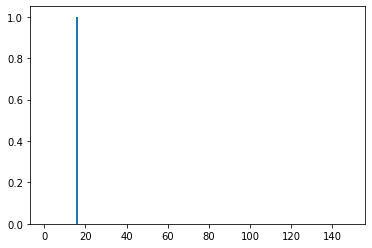

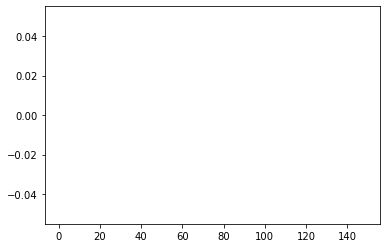

In [66]:
from torch_geometric.data import DataLoader



cnt_dict = []
cnt_dict.append({i+1:0 for i in range(148)})
cnt_dict.append({i+1:0 for i in range(148)})

for tc,d  in enumerate(DataLoader(model.dataset['test'], batch_size = 1)):
        
    
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    #if(d.y == 0) : continue
    
    print(d.y)
    node = torch.tensor(range(1,149))
    ps,ss = model.model.get_att(d)
    #print(ps[0].shape, ps[1].shape, ps[2].shape)
    len_ps = len(ps)
    #print(len_ps)
    
    print('-----node-----')
    #node = node[ps[0]]
    #node = node[ps[1]]
    #node = node[ps[2]]
    for i in range(len_ps):
        node = node[ps[i]]
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        print(ps[i])
        print(ss[i])
        
    
    print(node)
    #print(ss[-1])
    #print(ss[-2])
    
    
    print(node[(ss[-1]>0.5)])
    for v in node[(ss[-1]>0.5)].tolist():
        cnt_dict[d.y][v] =  cnt_dict[d.y][v] + 1
    
    
    #if(tc >= 5): break
plt.figure(0)
print(dict(filter(lambda elem:elem[1]>=5, cnt_dict[0].items())).keys())
plt.bar(cnt_dict[0].keys(),cnt_dict[0].values())


plt.figure(1)
print(dict(filter(lambda elem:elem[1]>=6, cnt_dict[1].items())).keys())
plt.bar(cnt_dict[1].keys(),cnt_dict[1].values())



In [32]:
[ss_.shape for ss_ in ss]

[torch.Size([119]), torch.Size([96]), torch.Size([77])]

In [90]:
node = torch.tensor(range(148))
no

In [78]:

[ 6,  2,  8, 22, 18, 13,  9, 23, 11,  7,  5, 12]
[35, 20, 77, 19,  0, 15, 50, 26,  5, 17, 81, 28, 22, 24, 75,  9, 69, 36,
        11, 14, 16, 79, 47, 56,  6, 52, 94,  8,  1,  7, 45]

[6, 2, 8, 22, 18, 13, 9, 23, 11, 7, 5, 12]